In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq 
from scipy import signal
from scipy.fft import fftshift

In [18]:
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Blinking.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Physcial clincing right forearm.csv", sep=",")
df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/EEGdata-2024-144--15-54-35.csv", sep=",")
df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Measurement_labels/Label12024-144--15-54-35.csv", sep=",")
end = 1500
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,231830.156250,245361.015625,537167.8125,429873.25000,219740.187500,222977.703125,223063.625000,215705.437500
1,231938.078125,245431.906250,537205.0625,429913.84375,219797.140625,222995.500000,223158.312500,215791.796875
2,231949.062500,245451.671875,537206.8750,429909.62500,219810.906250,222991.828125,223192.906250,215817.453125
3,231828.109375,245374.328125,537150.5625,429850.53125,219750.109375,222963.937500,223107.968750,215738.421875
4,231734.218750,245297.265625,537094.6250,429798.06250,219688.953125,222938.187500,223011.234375,215652.234375
...,...,...,...,...,...,...,...,...
1495,231837.125000,245395.515625,529879.4375,424058.75000,219797.953125,223014.906250,223144.265625,215737.343750
1496,231819.250000,245365.750000,529860.3750,424046.21875,219773.890625,223009.437500,223099.750000,215699.078125
1497,231943.531250,245448.453125,529911.0625,424105.68750,219839.515625,223047.078125,223187.812500,215781.343750
1498,232026.671875,245512.828125,529937.2500,424133.03125,219887.000000,223058.703125,223269.000000,215850.890625


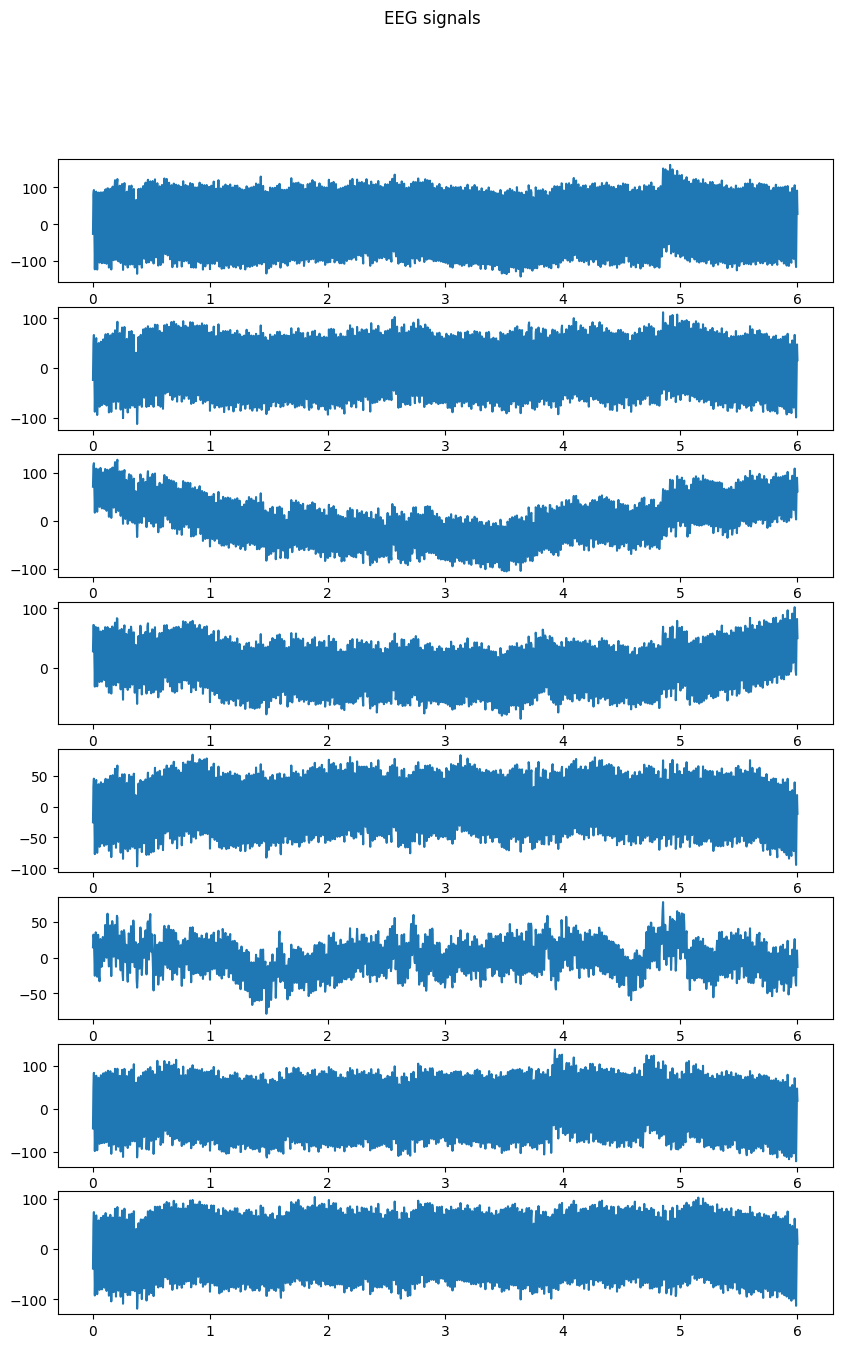

In [19]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

# Remove the DC component
df = signal.detrend(df, axis=0)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df[:,i])


In [40]:
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal

# Define the filter parameters
lowcut = 2
highcut = 30
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(8, [low, high], btype='band')

# Apply the filter to each column of the DataFrame
df_filt = lfilter(b, a, df, axis = 0)

# import scipy.signal as signal

# Define the notch filter parameters
fs = 250  # Sampling frequency
f0 = 50  # Notch frequency
Q = 50 # Quality factor

# Design the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply the filter to each column of the DataFrame
df_filt1 = lfilter(b, a, df_filt)

In [41]:
# Remove the DC component
#df_filt1 = signal.detrend(df_filt1, axis = 0)

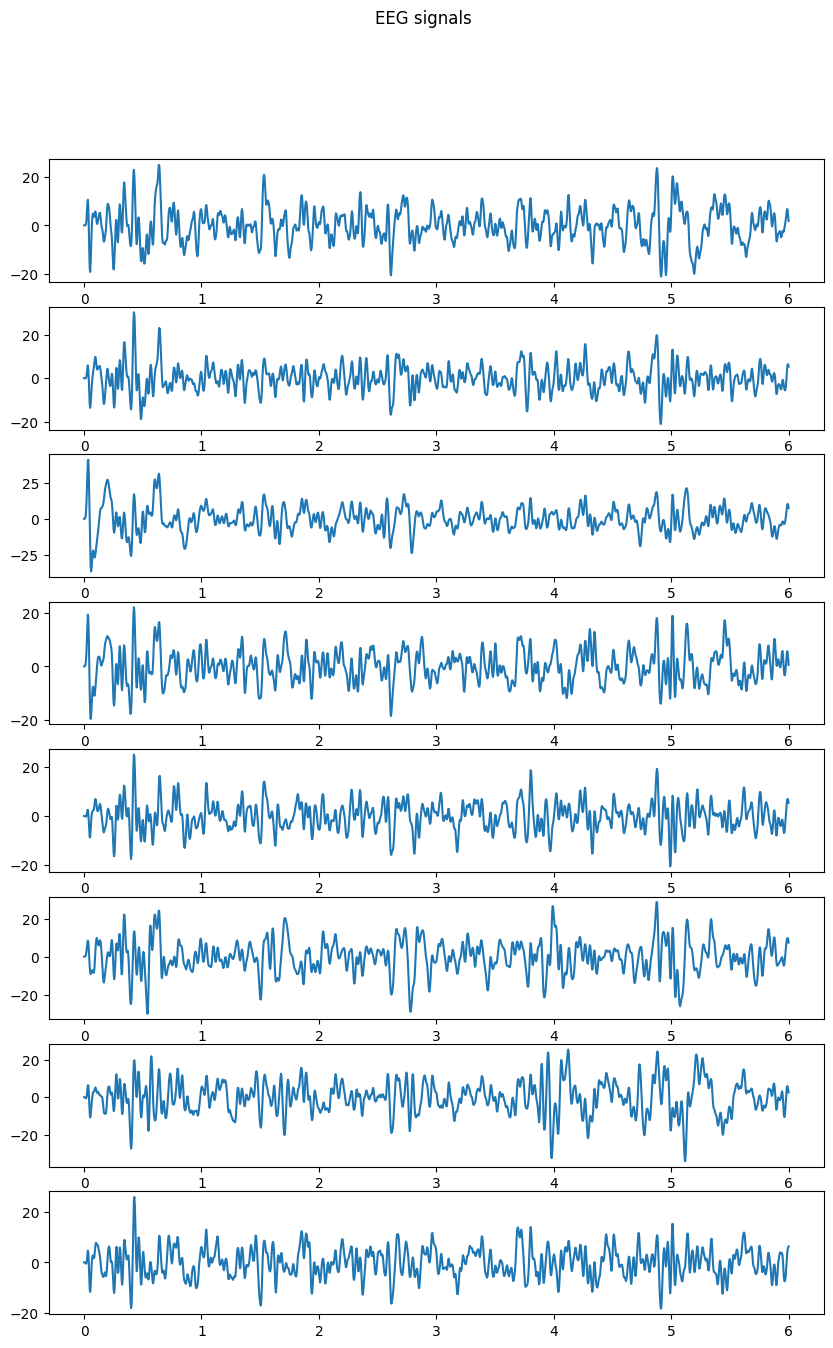

In [42]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df_filt1[:,i])

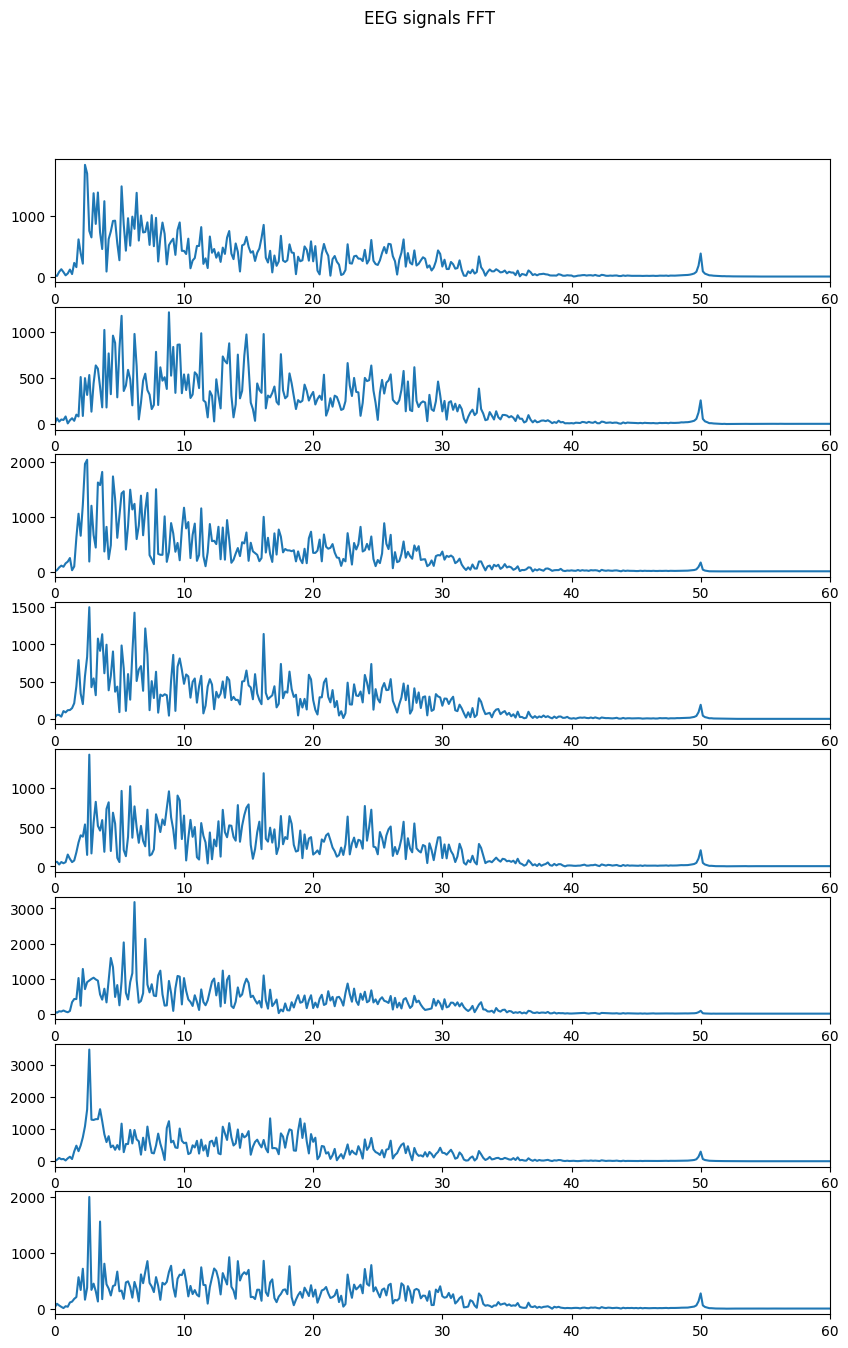

In [43]:
xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals FFT')
for i in range(8):
    yf = rfft(df_filt1[:,i])
    axs[i].plot(xf, np.abs(yf))
    axs[i].set_xlim([0, 60])
    # Setting the number of ticks 
    axs[i].locator_params(axis='x', nbins=10)
    

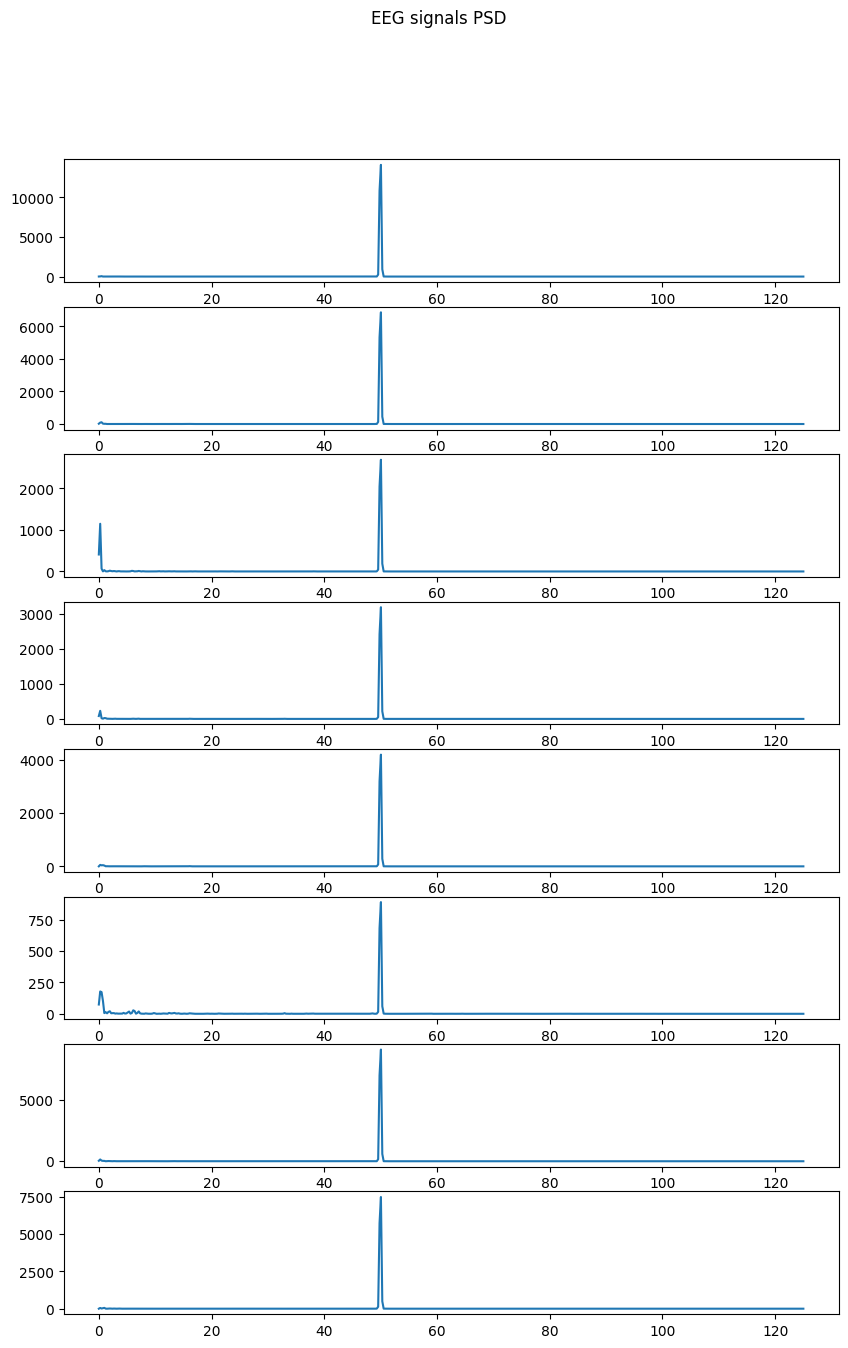

In [44]:
from scipy import signal

xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals PSD')
for i in range(8):
    # Compute the power spectral density
    frequencies, power_density = signal.welch(df[:,i], fs, nperseg=1024, scaling='density')


    # Plot the power spectral density
    axs[i].plot(frequencies, power_density)
    #plt.psd(df[:,i], Fs = 250)
    #axs[i].xlabel('Frequency (Hz)')
    #axs[i].ylabel('Power Spectral Density')
    #axs[i].title('Power Spectral Density Plot')


